In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyraf.iraf import artdata
from astropy.io import fits
from astropy.wcs import WCS
from sklearn import svm

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer,MinMaxScaler
from sklearn.linear_model import LogisticRegression


import astropy.coordinates as coords
import astropy.units as u
import subprocess as sp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seWrapper
reload(seWrapper)

SyntaxError: invalid syntax (seWrapper.py, line 343)

In [ ]:
phot = seWrapper.seCatalog()
phot.createNewCatalog('g_cfht_cropped.cat','g')

#phot.mergeCatalog(fake_stars.recovered_cat,match_rad=1*u.arcsec)

In [101]:

#new_cat = seWrapper.seCatalog()
#new_cat.createNewCatalog('r_crop.cat','r')

#phot.mergeCatalog(new_cat,match_rad=1*u.arcsec)

fake_stars = seWrapper.fakeStarTests('ngvs_bg_1_g_crop.fits',\
                                     phot,config_file='g.sex',seeing=3.,zpt=30.0,pix_scale=0.187)

In [102]:
fake_stars.genFakeCatalogs(n_stars=1000,min_mag=24,max_mag=26,n_iter=10,overwrite=True)

In [103]:
fake_stars.fake_cats.keys()

['1', '0', '3', '2', '5', '4', '7', '6', '9', '8']

In [86]:
phot_cat = fake_stars.phot
starlist_cat = fake_stars.starlist_cat
recovered_cat = fake_stars.recovered_cat
unrec_cat = fake_stars.unrec_cat

In [104]:
diff = np.array([])
mag = np.array([])
y = np.array([])
x = np.array([])
for i in fake_stars.fake_cats.keys():
    diff = np.append(diff,fake_stars.fake_cats[i][0,:] - fake_stars.fake_cats[i][1,:])
    mag = np.append(mag,fake_stars.fake_cats[i][0,:])
    x = np.append(x,fake_stars.fake_cats_x[i][:])
    y = np.append(y,fake_stars.fake_cats_y[i][:])
    
#x = (x-np.min(x)) / (np.max(x) - np.min(x))
#y = (y-np.min(y)) / (np.max(y) - np.min(y)) 
#mag = (mag-np.min(mag)) / (np.max(mag) - np.min(mag)) 

mag = np.array([mag]).T
y = np.array([y]).T
x = np.array([x]).T
data = np.hstack((mag,x,y))
det = np.abs(diff) > 2.0
small_data = data[:5000,:]
classify = det.astype(int)
small_classify=classify[:5000]
classify_small = small_classify

In [ ]:
small_data.shape

In [ ]:
x_bins=20.
y_bins=20.
mags_holder = dict()
classify_holder = dict()
mags_binned = np.zeros((x_bins,y_bins))

for (i,j),value in np.ndenumerate(mags_binned):
    i_low = i/x_bins*(np.max(x) - np.min(x))
    i_high = (i+1)/x_bins*(np.max(x) - np.min(x))
    j_low = j/y_bins*(np.max(y) - np.min(y))
    j_high = (j+1)/y_bins*(np.max(y) - np.min(y))
    select = (x < i_high) & (x > i_low) & (y < j_high) & (y > j_low)
    mags_holder[str(i)+'_'+str(j)] = mag[select]
    classify_holder[str(i)+'_'+str(j)] = classify[select[:,0]]
    

In [105]:
#scale the data
scaler_x = StandardScaler()
scaler_y = StandardScaler()
scaler_mag = StandardScaler()
scale_x = scaler_x.fit_transform(x)
scale_y = scaler_y.fit_transform(y)
scale_mag = scaler_mag.fit_transform(mag)
scale_x = (x - np.min(x)) / (np.max(x) - np.min(x))
scale_y = (y - np.min(y)) / (np.max(y) - np.min(y))
scale_mag = (mag - np.min(mag)) / (np.max(mag) - np.min(mag))

scale_data = np.hstack((scale_mag,scale_x,scale_y))
scale_data_small = scale_data[:,:]
small_classify=classify[:]
classify_small = small_classify

In [ ]:
normalizer = Normalizer()
print normalizer.fit_transform(x)

In [ ]:
mach = svm.SVC(probability=False,kernel='poly',cache_size=1000,degree=3,coef0=1000,C=0.316)
mach.fit(scale_data_small,small_classify)

In [106]:
#cross validation testing
c_search = np.logspace(-3.0,3.0,7)
gamma_search = np.logspace(-3.0,3.0,7)
param_grid = dict(C=c_search,gamma=gamma_search)
cv = StratifiedShuffleSplit(classify_small,n_iter=5,test_size=0.2)
grid = GridSearchCV(svm.SVC(kernel='rbf',cache_size=1000),param_grid=param_grid,cv=cv)
grid.fit(scale_data_small,classify_small)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
#for gamma in C_s:
#    mach.gamma = gamma
#    this_scores = cv.cross_val_score(mach, data, classify, n_jobs=-1)
#    scores.append(np.mean(this_scores))
#    scores_std.append(np.std(this_scores))
    
    
#plt.figure(1, figsize=(4, 3))
#plt.clf()
#plt.semilogx(C_s, scores)
#plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
#plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
#locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
#plt.ylabel('CV score')
#plt.xlabel('Parameter C')
#plt.show()

The best parameters are {'C': 0.10000000000000001, 'gamma': 1.0} with a score of 0.92


In [61]:
np.logspace(-1.5,0.5,3)

array([ 0.03162278,  0.31622777,  3.16227766])

In [107]:
machine = svm.SVC(C=0.1,probability=True,kernel='rbf',cache_size=1000,gamma=1.0)
machine.fit(scale_data_small,classify_small)

SVC(C=0.1, cache_size=1000, class_weight=None, coef0=0.0, degree=3, gamma=1.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

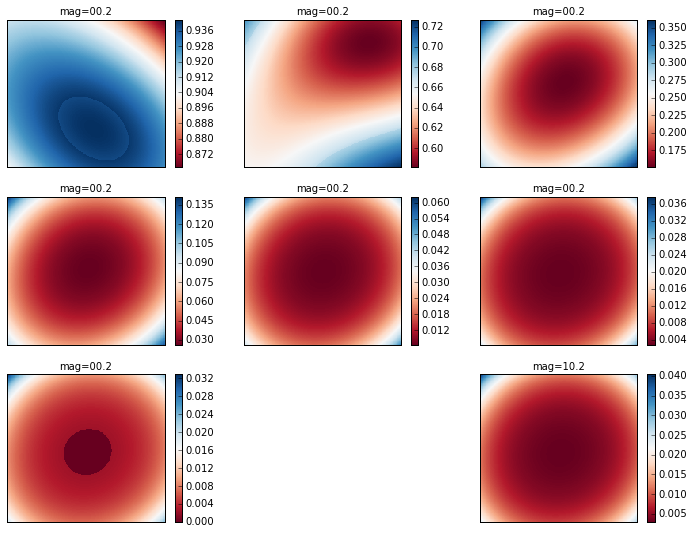

In [108]:
plt.figure(figsize=(12, 9))
mag_range = np.linspace(0.0,1.0,9.)
xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 200), np.linspace(0.0, 1.0, 200))
z_holder = np.zeros((xx.size,11))
for k in mag_range:
    # evaluate decision function in a grid
    Z = machine.predict_proba(np.c_[np.zeros(xx.size)+k,xx.ravel(), yy.ravel()])
    Z = Z[:,0].reshape(xx.shape)
    z_holder[:,int((k)*9.)] = Z.ravel()
    
    # visualize decision function for these parameters
    plt.subplot(3, 3,int((k)*9.))
    plt.title("mag=%d0.2" % k,
              size='medium')

    # visualize parameter's effect on decision function
    clr = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.colorbar(clr)

    #plt.scatter(scale_data_small[:, 1], scale_data_small[:, 2], c=classify_small, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

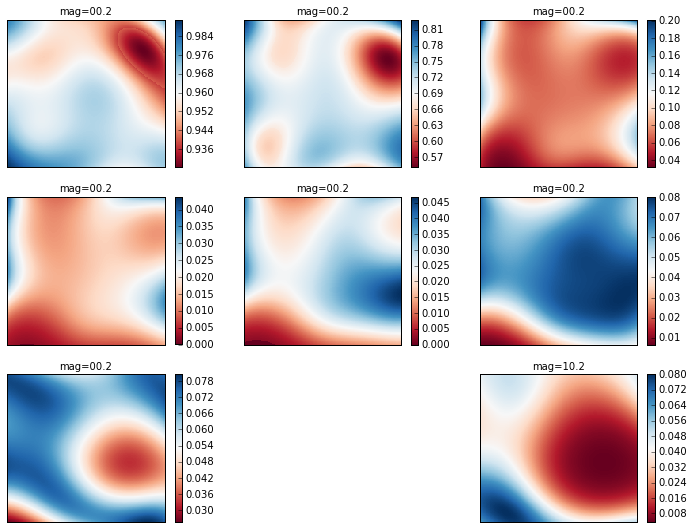

In [99]:
plt.figure(figsize=(12, 9))
mag_range = np.linspace(0.0,1.0,9.)
xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 200), np.linspace(0.0, 1.0, 200))
z_holder = np.zeros((xx.size,11))
for k in mag_range:
    # evaluate decision function in a grid
    Z = machine.predict_proba(np.c_[np.zeros(xx.size)+k,xx.ravel(), yy.ravel()])
    Z = Z[:,0].reshape(xx.shape)
    z_holder[:,int((k)*9.)] = Z.ravel()
    
    # visualize decision function for these parameters
    plt.subplot(3, 3,int((k)*9.))
    plt.title("mag=%d0.2" % k,
              size='medium')

    # visualize parameter's effect on decision function
    clr = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.colorbar(clr)

    #plt.scatter(scale_data_small[:, 1], scale_data_small[:, 2], c=classify_small, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

In [84]:
np.max(scaler_mag.inverse_transform(mag_range))

25.672325021764934

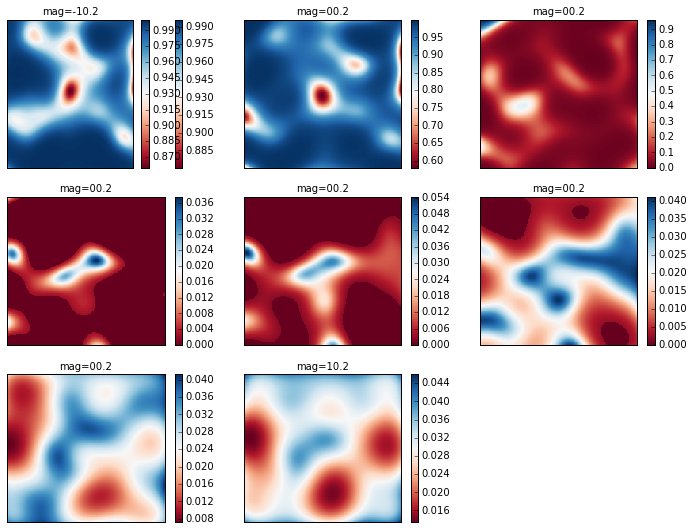

In [64]:
plt.figure(figsize=(12, 9))
mag_range = np.arange(-1.5,1.5,3./9.)
xx, yy = np.meshgrid(np.linspace(-1.77, 1.77, 200), np.linspace(-1.77, 1.77, 200))
z_holder = np.zeros((xx.size,11))
for k in mag_range:
    # evaluate decision function in a grid
    Z = machine.predict_proba(np.c_[np.zeros(xx.size)+k,xx.ravel(), yy.ravel()])
    Z = Z[:,0].reshape(xx.shape)
    z_holder[:,int((k+1.5)*9/3.)] = Z.ravel()
    
    # visualize decision function for these parameters
    plt.subplot(3, 3,int((k+1.5)*9/3. + 1))
    plt.title("mag=%d0.2" % k,
              size='medium')

    # visualize parameter's effect on decision function
    clr = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.colorbar(clr)

    #plt.scatter(scale_data_small[:, 1], scale_data_small[:, 2], c=classify_small, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

In [51]:
scaler_x.inverse_transform([-1.77])

array([ 8.67821346])

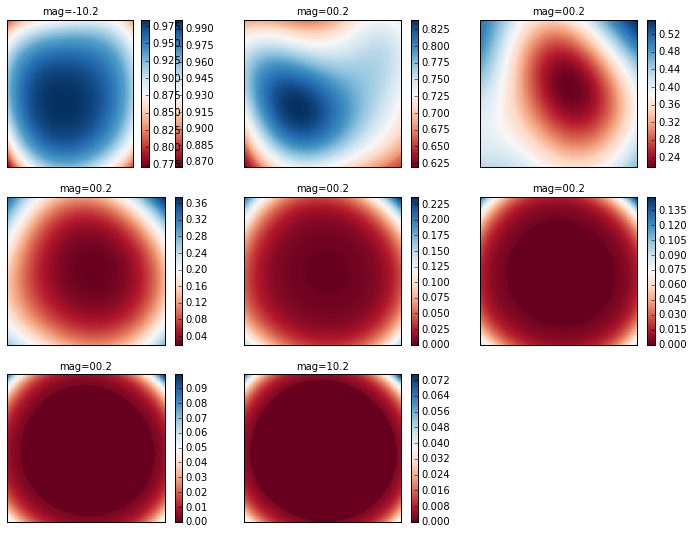

In [30]:
plt.figure(figsize=(12, 9))
mag_range = np.arange(-1.5,1.5,3./9.)
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
z_holder = np.zeros((xx.size,11))
for k in mag_range:
    # evaluate decision function in a grid
    Z = machine.predict_proba(np.c_[np.zeros(xx.size)+k,xx.ravel(), yy.ravel()])
    Z = Z[:,0].reshape(xx.shape)
    z_holder[:,int((k+1.5)*9/3.)] = Z.ravel()
    
    # visualize decision function for these parameters
    plt.subplot(3, 3,int((k+1.5)*9/3. + 1))
    plt.title("mag=%d0.2" % k,
              size='medium')

    # visualize parameter's effect on decision function
    clr = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.colorbar(clr)

    #plt.scatter(scale_data_small[:, 1], scale_data_small[:, 2], c=classify_small, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

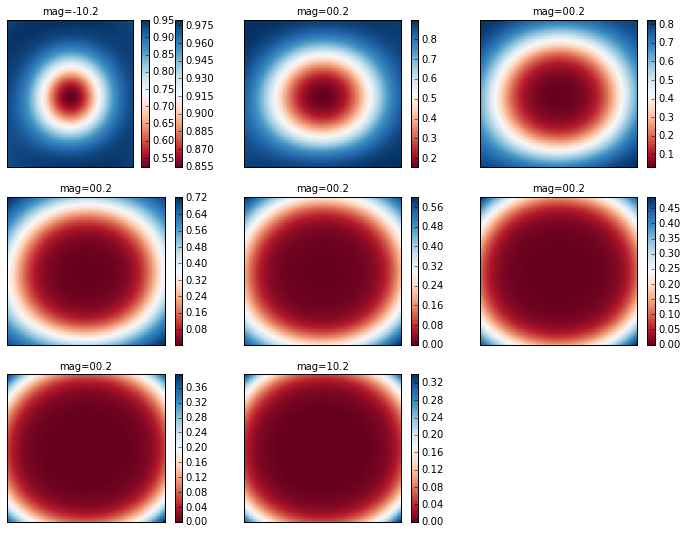

In [21]:
plt.figure(figsize=(12, 9))
mag_range = np.arange(-1.5,1.5,3./9.)
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
z_holder = np.zeros((xx.size,11))
for k in mag_range:
    # evaluate decision function in a grid
    Z = machine.predict_proba(np.c_[np.zeros(xx.size)+k,xx.ravel(), yy.ravel()])
    Z = Z[:,0].reshape(xx.shape)
    z_holder[:,int((k+1.5)*9/3.)] = Z.ravel()
    
    # visualize decision function for these parameters
    plt.subplot(3, 3,int((k+1.5)*9/3. + 1))
    plt.title("mag=%d0.2" % k,
              size='medium')

    # visualize parameter's effect on decision function
    clr = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.colorbar(clr)

    #plt.scatter(scale_data_small[:, 1], scale_data_small[:, 2], c=classify_small, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

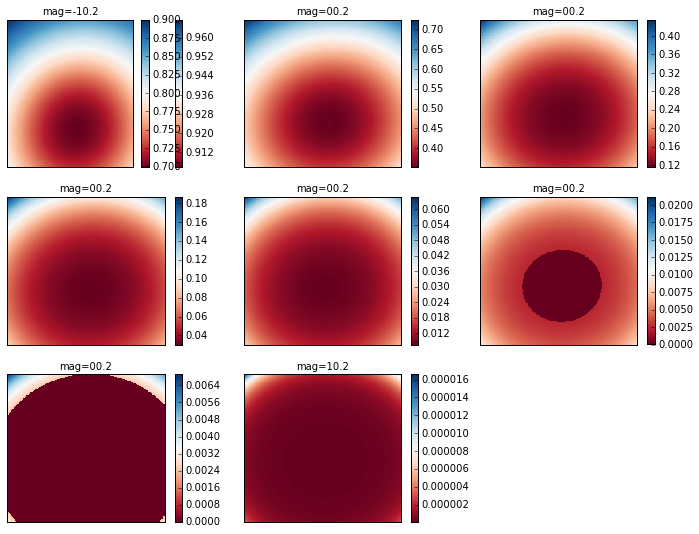

In [16]:
plt.figure(figsize=(12, 9))
mag_range = np.arange(-1.5,1.5,3./9.)
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
z_holder = np.zeros((xx.size,11))
for k in mag_range:
    # evaluate decision function in a grid
    Z = machine.predict_proba(np.c_[np.zeros(xx.size)+k,xx.ravel(), yy.ravel()])
    Z = Z[:,0].reshape(xx.shape)
    z_holder[:,int((k+1.5)*9/3.)] = Z.ravel()
    
    # visualize decision function for these parameters
    plt.subplot(3, 3,int((k+1.5)*9/3. + 1))
    plt.title("mag=%d0.2" % k,
              size='medium')

    # visualize parameter's effect on decision function
    clr = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.colorbar(clr)

    #plt.scatter(scale_data_small[:, 1], scale_data_small[:, 2], c=classify_small, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

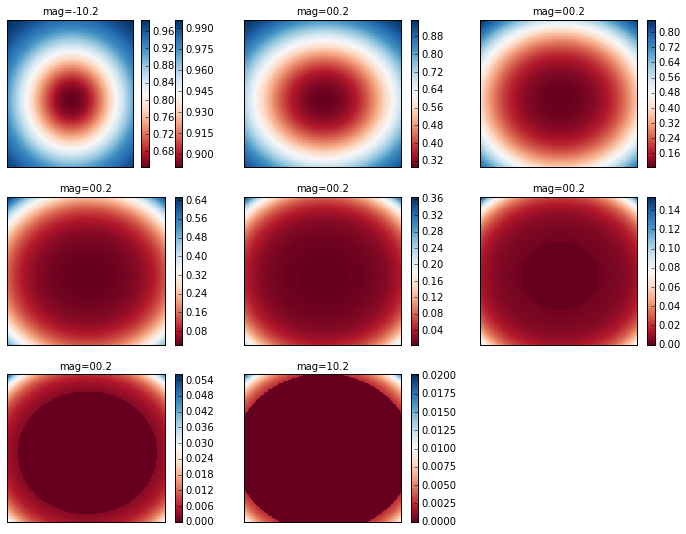

In [14]:
plt.figure(figsize=(12, 9))
mag_range = np.arange(-1.5,1.5,3./9.)
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
z_holder = np.zeros((xx.size,11))
for k in mag_range:
    # evaluate decision function in a grid
    Z = machine.predict_proba(np.c_[np.zeros(xx.size)+k,xx.ravel(), yy.ravel()])
    Z = Z[:,0].reshape(xx.shape)
    z_holder[:,int((k+1.5)*9/3.)] = Z.ravel()
    
    # visualize decision function for these parameters
    plt.subplot(3, 3,int((k+1.5)*9/3. + 1))
    plt.title("mag=%d0.2" % k,
              size='medium')

    # visualize parameter's effect on decision function
    clr = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.colorbar(clr)

    #plt.scatter(scale_data_small[:, 1], scale_data_small[:, 2], c=classify_small, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

In [12]:
scaler.inverse_transform(mag_range)

array([ 20.21188267,  20.49896294,  20.78604321,  21.07312349,
        21.36020376,  21.64728404,  21.93436431,  22.22144459,  22.50852486])

In [ ]:
fig,ax = plt.subplots()
color = ax.pcolormesh(xx,yy,z_holder[:,5].reshape(xx.shape),cmap=plt.cm.RdBu)
fig.colorbar(color)

In [ ]:
#now try some logistic regression methods
logit = LogisticRegression()
x2 = x**2
y2 = y**2
xy = x * y
scale_data = np.hstack((scale_mag,x,y,x2,y2,xy))
logit.fit(scale_data,classify)

In [ ]:
logit.coef_

In [ ]:
fig,ax = plt.subplots(figsize=(7,5),dpi=1000)

inds = np.array([np.arange(0.0,1.0,0.01)]).T
foo = (np.ones(inds.size)*0.4).T
foo_y = (np.ones(inds.size)*0.5).T
stack = np.vstack((foo,inds[:,0],foo)).T
probs = mach.predict_proba(stack)
ax.plot(inds,probs[:,0])
ax.set_xlabel('Input g Magnitude',fontsize=18)
ax.set_ylabel('Recovery Probability',fontsize=18)

In [ ]:
grid_a,grid_b,grid_c = np.meshgrid(inds,inds,inds)
a_flat=grid_a.flatten()
b_flat=grid_b.flatten()
c_flat=grid_c.flatten()

stack=np.vstack([a_flat,b_flat,c_flat]).T
probs = mach.predict_proba(stack)
probs_reshape = probs[:,0].reshape(inds.size,inds.size,inds.size)

In [ ]:
#calculate the magnitude where 50% of stars are returned for each location
half_mags = np.zeros((100,100))
for (x,y),value in np.ndenumerate(half_mags):
    half_mags[x,y] = np.argmin(np.abs(probs_reshape[x,:,y]-0.90))
    


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a_flat,b_flat,half_mags.flatten)

In [ ]:
C_s

In [ ]:
print diff[0:100]

In [ ]:
some_coords  = coords.SkyCoord(ra=202.30467*u.degree,dec=21.129682*u.degree)
foo_coords_ra,foo_coords_dec = fake_stars.wcs.wcs_world2pix(some_coords.ra*u.degree,some_coords.dec*u.degree,1)
print foo_coords_ra,foo_coords_dec

In [ ]:
plt.hist(diff)

In [ ]:
new_coords = coords.SkyCoord(ra = phot_cat.coords.ra[bad],dec=phot_cat.coords.dec[bad])
starlist_cat.coords = new_coords
starlist_cat.coordPrint('foo')
phot_cat.coordPrint('phot')

In [ ]:
old_phot = fake_stars.starlist_cat.mags['g'] < 99.999
fake_stars.starlist_cat.mags['g'][old_phot] - fake_stars.starlist_cat.mags['recovered'][old_phot]

In [ ]:
phot_cat.all_detected

In [ ]:
b = np.arange(10)
c = b < 5
b[~c]

In [ ]:
fake_stars.phot.mags['g']- fake_stars.phot.mags['recovered']